<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Trabajo Final de Estudios</header1></center>
<center><h1>Predicción de la evolución de criptomonedas en Binance mediante IA</header1></center>
<center><h1>ARIMA</header1></center>

Trabajo fin de estudio presentado por: **Jorge Manuel Ibáñez Vázquez** <br>
Tipo de trabajo:                       Piloto experimental <br>
Director:                              Luis Guadalupe Macías Trejo <br>
Fecha:                                 17/04/2025

## Resumen
El modelo ARIMA se utilizó como un punto de comparación tradicional para la predicción de series temporales.
- Fuentes de Datos: Los datos históricos horarios para el modelo ARIMA, específicamente para BTC/USD, se obtuvieron de Binance con un intervalo horario (1h). Al igual que en el modelo de regresión, se priorizó la carga desde un CSV local (btc_hour_analizar_arima.csv) para agilizar el proceso y evitar descargas redundantes.



## Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta
import joblib
from binance.client import Client

## Buscar los mejores parámetros para ARIMA (p,d,q)

### Función para predecir (p,d,q)

In [2]:
def seleccionar_orden_arima(serie_temporal, max_p=5, max_d=2, max_q=5):
    """
    Selecciona el mejor orden (p, d, q) para un modelo ARIMA basado en el AIC.

    Args:
        serie_temporal (pd.Series): La serie temporal a modelar.
        max_p (int): Máximo valor para el orden AR (p).
        max_d (int): Máximo valor para el orden de diferenciación (d).
        max_q (int): Máximo valor para el orden MA (q).

    Returns:
        tuple: El mejor orden (p, d, q) encontrado.
        ARIMA: El modelo ARIMA entrenado con el mejor orden.
    """
    mejor_aic = float("inf")
    mejor_orden = None
    mejor_modelo = None

    # 1. Prueba de estacionariedad ADF para sugerir d
    print("Resultados de la prueba ADF:")
    resultado_adf = adfuller(serie_temporal)
    print(f"Estadístico ADF: {resultado_adf[0]:.3f}")
    print(f"Valor p: {resultado_adf[1]:.3f}")

    if resultado_adf[1] > 0.05:
        print("La serie no es estacionaria. Se probará con d = 1 y d = 2.")
        d_values = [1, 2]
    else:
        print("La serie es estacionaria. Se probará con d = 0.")
        d_values = [0]

    # 2. Búsqueda de los mejores parámetros p, d, q
    for d in d_values:
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                orden_actual = (p, d, q)
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")

                        # Forzar frecuencia horaria si no se puede inferir
                        serie_temporal = serie_temporal.sort_index()  # Asegura orden correcto

                        if pd.infer_freq(serie_temporal.index) is None:
                            print("⚠️ Frecuencia no inferida. Se usará frecuencia horaria forzada.")
                            serie_temporal = serie_temporal.asfreq("H")
                        else:
                            serie_temporal = serie_temporal.asfreq(pd.infer_freq(serie_temporal.index))

                        modelo = ARIMA(serie_temporal, order=orden_actual)
                        resultado = modelo.fit()

                    aic_actual = resultado.aic
                    print(f"ARIMA{orden_actual} - AIC: {aic_actual:.3f}")

                    if aic_actual < mejor_aic:
                        mejor_aic = aic_actual
                        mejor_orden = orden_actual
                        mejor_modelo = resultado
                except Exception as e:
                    print(f"Error al ajustar ARIMA{orden_actual}: {e}")
                    continue  # Ignorar combinaciones que dan error

    if mejor_modelo:
        print("\n✅ Mejor modelo encontrado:")
        print(f"Orden: {mejor_orden}")
        print(f"AIC: {mejor_aic:.3f}")
    else:
        print("\n❌ No se pudo ajustar ningún modelo ARIMA exitosamente.")

    return mejor_orden, mejor_modelo

### Hay que eliminar los multi-índices para trabajar con los dataframes de forma correcta

In [9]:
# --- MIS CLAVES API DE BINANCE ---
API_KEY = '2POZsiboHQwbAIH4RcMxNu2ZSSxNC2eSG1rEDIbQNIrGDZ6EVkxFwa04oFfs3ACw'
API_SECRET = 'YJGcEy8XPyzsVjKH2GrGCRmxRp2Gg0klvJNwtPO8e4Mjl3SleXyKHLmwCiUi1aRW'
# ---------------------------------

# Inicializar el cliente de Binance
client = Client(API_KEY, API_SECRET)

# Función para simplificar el multiíndice (mantenemos la versión genérica que es más segura)
def simplificar_multiindice(df):
    """
    Simplifica el MultiIndex de columnas si existe, dejando solo el último nivel.
    Esta función es más robusta y no asume nombres específicos de niveles.
    """
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(-1)
        df.columns.name = None
    return df

csv_file_name = "btc_hour_analizar_arima.csv"  # Nombre del archivo CSV
symbol = "BTCUSDT" # El símbolo para BTC/USD en Binance es BTCUSDT
interval_binance = Client.KLINE_INTERVAL_1HOUR # Intervalo de 1 hora para Binance API

# Fecha de inicio para los datos a añadir (desde 2025-01-01)
start_date_to_add = datetime(2025, 1, 1)
# Fecha de fin: hoy
end_date_current = datetime.now()

#start_date_download = start_date_download.replace(tzinfo=None)
#end_date_current = end_date_current.replace(tzinfo=None)

# Inicializar un DataFrame vacío para los datos existentes o nuevos
data_BTC_hour = pd.DataFrame()
start_date_download = start_date_to_add # Por defecto, la fecha de inicio de descarga

try:
    # Intentar cargar desde CSV
    # Al cargar, asumimos que 'Date' es la columna de índice
    data_BTC_hour = pd.read_csv(csv_file_name, index_col='Date', parse_dates=True)
    print("✅ Datos cargados desde CSV.")

    # Asegurar que 'Close' sea numérica y eliminar NaNs
    data_BTC_hour['Close'] = pd.to_numeric(data_BTC_hour['Close'], errors='coerce')
    data_BTC_hour = data_BTC_hour.dropna(subset=['Close'])

    # Determinar la última fecha existente en el CSV
    last_date_in_csv = data_BTC_hour.index.max()
    print(f"Última fecha en el CSV: {last_date_in_csv}")

    # Si la última fecha en el CSV es anterior a la fecha actual,
    # ajustamos la fecha de inicio de descarga para que comience después.
    if last_date_in_csv and last_date_in_csv < end_date_current:
        # Añadir una hora al último timestamp para evitar duplicados si el intervalo es horario
        start_date_download = last_date_in_csv + timedelta(hours=1)
        # Asegurarse de que no descargue datos anteriores a 2025-01-01 si el CSV ya está actualizado hasta antes
        if start_date_download < start_date_to_add:
            start_date_download = start_date_to_add
    else:
        # Si el CSV ya está completamente actualizado o no hay datos,
        # la descarga comenzará desde start_date_to_add.
        start_date_download = start_date_to_add

    print(f"Comenzando descarga desde: {start_date_download.strftime('%Y-%m-%d %H:%M:%S')} (después de la última fecha en CSV o desde 2025-01-01).")

except FileNotFoundError:
    print(f"⚠️ El archivo '{csv_file_name}' no se encontró. Se descargará todo desde {start_date_to_add.date()}.")
    start_date_download = start_date_to_add
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print(f"⬇️ Se intentará descargar todo desde {start_date_to_add.date()} debido al error.")
    start_date_download = start_date_to_add


# Descargar datos desde la fecha de inicio calculada hasta la fecha actual de Binance
if start_date_download < end_date_current:
    print(f"Descargando datos adicionales de Binance desde {start_date_download.date()} hasta {end_date_current.date()}...")

    # Binance API tiene un límite de 1000 klines por llamada.
    # Iteramos en bloques hasta alcanzar la fecha de fin.
    current_start_timestamp = int(start_date_download.timestamp() * 1000) # Convertir a milisegundos para Binance
    end_timestamp = int(end_date_current.timestamp() * 1000)

    all_klines = []
    # Límite de 1000 para el número de klines
    limit = 1000

    while current_start_timestamp < end_timestamp:
        print(f"Descargando bloque desde: {datetime.fromtimestamp(current_start_timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')}")
        try:
            klines = client.get_historical_klines(
                symbol,
                interval_binance,
                str(current_start_timestamp), # Start time en milisegundos como string
                # str(min(current_start_timestamp + (limit * 3600 * 1000), end_timestamp)) # Cálculo de fin
                # La API de Binance puede manejar un 'endTime' o simplemente la cantidad 'limit'
                # Si no se especifica 'endTime', devuelve 'limit' desde 'startTime'
            )
            if not klines:
                break # No hay más datos
            all_klines.extend(klines)
            # Actualizar el current_start_timestamp al timestamp del último kline + 1 hora
            # El kline[0] es el Open time en milisegundos
            current_start_timestamp = klines[-1][0] + (1 * 3600 * 1000) # Sumar una hora en milisegundos

            # Si el último kline descargado es el final de nuestro rango, salir del bucle
            if klines[-1][0] >= end_timestamp:
                break

        except Exception as e:
            print(f"Error al descargar bloque de datos de Binance: {e}")
            break # Salir del bucle en caso de error grave

    if all_klines:
        # Convertir los klines a un DataFrame
        new_data = pd.DataFrame(all_klines, columns=[
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close time', 'Quote asset volume', 'Number of trades',
            'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
        ])

        # Convertir 'Open time' a datetime y establecerlo como índice
        new_data['Open time'] = pd.to_datetime(new_data['Open time'], unit='ms')
        new_data = new_data.set_index('Open time')
        new_data.index.name = 'Date' # Renombrar el índice a 'Date'

        # Convertir las columnas numéricas a float
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            new_data[col] = pd.to_numeric(new_data[col], errors='coerce')

        # Mantener solo las columnas deseadas y reordenarlas
        columns_to_keep_final = ['Close', 'High', 'Low', 'Open', 'Volume']
        new_data = new_data[columns_to_keep_final]

        # Concatenar los datos existentes con los nuevos
        if data_BTC_hour.empty:
            data_BTC_hour = new_data
        else:
            data_BTC_hour = pd.concat([data_BTC_hour, new_data])
            # Eliminar duplicados después de la concatenación
            data_BTC_hour = data_BTC_hour[~data_BTC_hour.index.duplicated(keep='first')]
            # Forzar conversión del índice a datetime
            data_BTC_hour.index = pd.to_datetime(data_BTC_hour.index, errors='coerce')
            # Ordenar por índice (fecha)
            data_BTC_hour = data_BTC_hour.sort_index()

        # Guardar el DataFrame actualizado en el CSV
        # Aseguramos que 'Date' (el índice) se guarde como columna
        data_BTC_hour.to_csv(csv_file_name, index=True)
        print(f"✅ Datos descargados de Binance y actualizados en {csv_file_name}")
    else:
        print("No se descargaron nuevos datos de Binance o no hay datos disponibles en el rango especificado.")
else:
    print("El CSV ya está actualizado hasta la fecha solicitada o no hay nuevos datos que añadir desde Binance.")

# Mostrar primeras filas del DataFrame final
print("\nPrimeras filas del DataFrame final:")
print(data_BTC_hour.head())

# Mostrar últimas filas del DataFrame final
print("\nÚltimas filas del DataFrame final:")
print(data_BTC_hour.tail())


df = data_BTC_hour['Close'].copy()
serie_temporal = df
serie_temporal.index = pd.to_datetime(serie_temporal.index)  # Asegurar índice datetime

✅ Datos cargados desde CSV.
Última fecha en el CSV: 2025-06-28 10:00:00
Comenzando descarga desde: 2025-06-28 11:00:00 (después de la última fecha en CSV o desde 2025-01-01).
Descargando datos adicionales de Binance desde 2025-06-28 hasta 2025-06-28...
No se descargaron nuevos datos de Binance o no hay datos disponibles en el rango especificado.

Primeras filas del DataFrame final:
                        Close      High       Low      Open     Volume
Date                                                                  
2024-12-31 23:00:00  93576.00  93756.00  93375.38  93488.83  336.57995
2025-01-01 00:00:00  94401.14  94509.42  93489.03  93576.00  755.99010
2025-01-01 01:00:00  93607.74  94408.72  93578.77  94401.13  586.53456
2025-01-01 02:00:00  94098.91  94105.12  93594.56  93607.74  276.78045
2025-01-01 03:00:00  93838.04  94098.91  93728.22  94098.90  220.99302

Últimas filas del DataFrame final:
                         Close       High        Low       Open     Volume
Date   

In [10]:
# 3. Dividir los datos en entrenamiento y prueba (manteniendo índice)
split_idx = int(len(serie_temporal) * 0.8)
train = serie_temporal.iloc[:split_idx]
test = serie_temporal.iloc[split_idx:]
test.index = pd.to_datetime(test.index)

Resultados de la prueba ADF:
Estadístico ADF: -0.787
Valor p: 0.823
La serie no es estacionaria. Se probará con d = 1 y d = 2.
ARIMA(0, 1, 0) - AIC: 52586.815
ARIMA(0, 1, 1) - AIC: 52588.450
ARIMA(0, 1, 2) - AIC: 52590.357
ARIMA(0, 1, 3) - AIC: 52591.144
ARIMA(0, 1, 4) - AIC: 52591.943
ARIMA(0, 1, 5) - AIC: 52593.946
ARIMA(1, 1, 0) - AIC: 52588.453
ARIMA(1, 1, 1) - AIC: 52588.036
ARIMA(1, 1, 2) - AIC: 52592.106
ARIMA(1, 1, 3) - AIC: 52590.367
ARIMA(1, 1, 4) - AIC: 52594.150
ARIMA(1, 1, 5) - AIC: 52594.315
ARIMA(2, 1, 0) - AIC: 52590.369
ARIMA(2, 1, 1) - AIC: 52592.371
ARIMA(2, 1, 2) - AIC: 52592.008
ARIMA(2, 1, 3) - AIC: 52589.457
ARIMA(2, 1, 4) - AIC: 52595.319
ARIMA(2, 1, 5) - AIC: 52596.251
ARIMA(3, 1, 0) - AIC: 52591.121
ARIMA(3, 1, 1) - AIC: 52590.349
ARIMA(3, 1, 2) - AIC: 52592.027
ARIMA(3, 1, 3) - AIC: 52590.441
ARIMA(3, 1, 4) - AIC: 52592.334
ARIMA(3, 1, 5) - AIC: 52599.930
ARIMA(4, 1, 0) - AIC: 52591.857
ARIMA(4, 1, 1) - AIC: 52593.856
ARIMA(4, 1, 2) - AIC: 52595.162
ARIMA(4, 

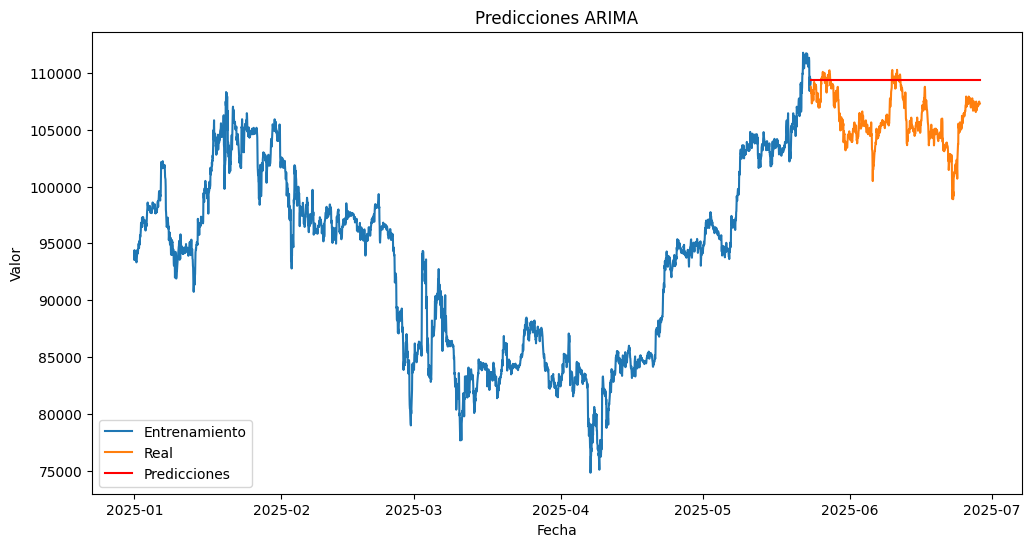

In [11]:
# 4. Seleccionar el mejor modelo ARIMA usando la función
mejor_orden, mejor_modelo = seleccionar_orden_arima(train)

if mejor_orden is not None:
    # 5. Hacer predicciones con el mejor modelo
    # Generar índice futuro basado en el último índice de entrenamiento
    frecuencia = pd.infer_freq(train.index)
    if frecuencia is None:
        frecuencia = 'H'  # Suponemos frecuencia horaria como fallback

    inicio_pred = train.index[-1] + pd.Timedelta(1, unit=frecuencia[0])
    nuevo_indice = pd.date_range(start=inicio_pred, periods=len(test), freq=frecuencia)

    # Predicción
    predicciones = mejor_modelo.forecast(steps=len(test))
    predicciones = pd.Series(predicciones, index=nuevo_indice)


    print(f"\nPredicciones:\n{predicciones.head()}")
    
    # 6. Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Entrenamiento")
    plt.plot(test, label="Real")
    plt.plot(predicciones, color="red", label="Predicciones")
    plt.title("Predicciones ARIMA")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
else:
    print("No se pudo encontrar un modelo ARIMA adecuado.")